# Explaining XGBoost model predictions with SHAP values: Analysis of hopsital SHAP values

Isolating the SHAP value (and SHAP main effect) for patients that attend a hospital, from the SHAP value (and SHAP main effect) for patients that do not attend a hospital

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In two other detailed notebooks (see GitHub repo for these notebooks: https://github.com/samuel-book/samuel_shap_paper_1), we looked at SHAP values (03a_xgb_shap_values_focus_on_ohe_hospitals.ipynb) and SHAP main effect (3b_xgb_combined_shap_key_features.ipynb) for the one-hot encoded hospital features. We looked at the values for patients that attend the hospital, and for those that do not (as we have seen that the hospital has a SHAP value when a patient attend another one, so there is a contribution to the prediction based on *not* attending a hospital). 

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we load an already fitted XGBoost model to the SAMueL dataset (in notebook 03a_xgb_shap_values_focus_on_ohe_hospitals.ipynb), to predict whether a patient recieves thrombolysis from the values of eight features. We calculate the SHAP values of this fitted model and explore the SHAP values and SHAP main effect values for each of the one-hot encoded hospital features.

## Model and data

XGBoost model was trained on all of the data (no test set used). The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (0 = No, 1 = Yes)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)
* Stroke team: Represented as one-hot encoded features

And one target feature:
* Thrombolysis: Did the patient recieve thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data to predict whether patient gets thrombolysis
* Calculate the SHAP values of the features
* Understand the SHAP values for the hospital one-hot encoded features

## Observations
* Both of the SHAP values and SHAP main effect values for the one-hot encoded hospital features are very dependent on whether the instance attended the hospital or not
* For the instances that attend a hospital, the SHAP main effect values are a narrower range than the equivalent SHAP values (due to the SHAP values being made up of the main effect and the pair-wise feature interactions).
* 56% of the variability in hospital thrombolysis rate can be explained by the SHAP main effect value for the one-hot encoded hospital feature (the mean of those instances that attend the hospital).
* 58% of the variability in hospital thrombolysis rate can be explained by the SHAP main effect value for the one-hot encoded hospital feature (the mean of those instances that attend the hospital).

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

import os
import pickle

import math # to .floor and .ceil

# So can take deep copy
import copy

from os.path import exists
import json

#import scipy.stats

/home/michael/miniconda3/envs/samuel/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Set filenames

In [2]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03c'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)   

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

For this exercise, we will fit a model using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty list
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

## Get list of feature names

In [7]:
feature_names = list(test_data_kfold[0])

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [8]:
X = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [9]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


### One-hot encode hospital feature

In [10]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X['Stroke team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)

## Load XGBoost model

An XGBoost model was trained on the full dataset (rather than train/test splits used to assess accuracy) in notebook 03a_xgb_shap_values_focus_on_ohe_hospitals.ipynb

In [11]:
# Load models
filename = (f'./saved_models/03a_{model_text}.p')
with open(filename, 'rb') as filehandler:
    model = pickle.load(filehandler)
        
# Get the predictions for each patient 
#   (the classification, and the probability of being in either class)
y_pred = model.predict(X)
y_pred_proba = model.predict_proba(X)

# Calculate the models accuracy
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.878


## SHAP values

SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios.

### Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

Load from pickle (saved from notebook 3a)

In [12]:
#filename = f'./output/03a_{model_text}_shap_explainer_object.p'
#file_exists = exists(filename)

#if file_exists:
#    # Load explainer
#    with open(filename, 'rb') as filehandler:
#        explainer = pickle.load(filehandler)
#else:
#    print("Run notebook 03a_xgb_shap_values_focus_on_ohe_hospitals.ipynb")
##    end

filename = f'./output/03a_{model_text}_shap_values_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP values
    with open(filename, 'rb') as filehandler:
        shap_values = pickle.load(filehandler)
else:
    print("Run notebook 03a_xgb_shap_values_focus_on_ohe_hospitals.ipynb")
#    end

The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [13]:
shap_values[0]

.values =
array([ 7.56502628e-01,  4.88319576e-01,  1.10273695e+00,  4.40223962e-01,
        4.98975307e-01,  2.02812225e-01, -2.62601525e-01,  3.69181409e-02,
        2.30234995e-01,  3.20923195e-04, -6.03703642e-03, -7.17267860e-04,
        0.00000000e+00, -4.91688668e-04,  1.20360847e-03,  1.77788886e-03,
       -4.34198463e-03, -2.76021136e-04, -2.79896380e-03,  3.52182891e-03,
       -2.73969141e-04,  8.53505917e-03, -5.28220041e-03, -8.25227005e-04,
        6.20208494e-03,  6.92215608e-03, -6.32244349e-03, -3.35367222e-04,
        7.81939551e-03, -4.71850217e-06, -4.25534381e-05,  6.48253039e-03,
        8.43156071e-04, -6.28353562e-04, -1.25156669e-02, -7.92063680e-03,
       -1.99409085e-03, -5.05548809e-03, -3.90118686e-03,  1.30317558e-03,
        0.00000000e+00, -6.48246554e-04,  1.19629130e-03,  8.26304778e-04,
        1.28053436e-02,  2.55714403e-03, -3.20375757e-03,  4.23251512e-03,
       -7.19791185e-03,  4.02670400e-03,  3.75146419e-03,  8.31848301e-04,
        3.45067

There is one of these for each instance.

In [14]:
shap_values.shape

(88792, 141)

#### Format the SHAP values data 

Features are in the same order in shap_values as they are in the original dataset.

Use this fact to extract the SHAP values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

Also include a column containing the Stroke team that each instance attended.

And three further columns: 
1) contribution from all the hospital features
2) contribution from attending the hospital
3) contribution from not attending the rest

In [15]:
# Get list of hospital one hot encoded column titles
hospital_names_ohe = X.filter(regex='^team',axis=1).columns
n_hospitals = len(hospital_names_ohe)

# Get list of hospital names without the prefix "team_"
hospital_names = [h[5:] for h in hospital_names_ohe]

# Create list of column index for these hospital column titles
hospital_columns_index = [X.columns.get_loc(col) for col in hospital_names_ohe]

# Use this index list to access the hosptial shap values (as array)
hosp_shap_values = shap_values.values[:,hospital_columns_index]
# Put in dataframe with hospital as column title
df_hosp_shap_values = pd.DataFrame(hosp_shap_values, columns = hospital_names)
# Include Stroke team that each instance attended
df_hosp_shap_values["Stroke team"] = X_combined["Stroke team"].values

# Store the sum of the SHAP values (for all of the hospital features)
df_hosp_shap_values["all_stroke_teams"] = df_hosp_shap_values.sum(axis=1)

# Initialise list for 1) SHAP value for attended hospital 2) SHAP value for 
#   the sum of the rest of the hospitals
shap_values_attended_hospital = []
shap_values_not_attend_these_hospitals = []

# For each patient
for index, row in df_hosp_shap_values.iterrows():

    # Get stroke team attended
    stroke_team = row["Stroke team"]
    
    # Get SHAP value for the stroke team attended
    shap_values_attended_hospital.append(row[stroke_team])

    # Calculate sum of SHAP values for the stroke teams not attend 
    sum_rest = row["all_stroke_teams"] - row[stroke_team]
    shap_values_not_attend_these_hospitals.append(sum_rest)

# Store two new columns in dataframe
df_hosp_shap_values["attended_stroke_team"] = shap_values_attended_hospital
df_hosp_shap_values["not_attended_stroke_teams"] = shap_values_not_attend_these_hospitals
                   
# View preview
df_hosp_shap_values.head()

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,Stroke team,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
0,0.000321,-0.006037,-0.000717,0.0,-0.000492,0.001204,0.001778,-0.004342,-0.000276,-0.002799,...,0.000720,0.000683,-0.001920,0.002390,-0.000897,0.004855,TXHRP7672C,-0.084398,-0.023110,-0.061287
1,0.001207,-0.002507,0.000081,0.0,-0.001356,0.001547,0.003449,-0.006348,-0.000127,-0.002576,...,0.000148,0.000683,-0.001825,0.000454,-0.001445,0.003970,SQGXB9559U,-0.760522,-0.671515,-0.089007
2,0.001492,-0.015246,0.002635,0.0,-0.000272,0.001399,0.002737,-0.007848,-0.000605,-0.002614,...,0.000135,0.000262,-0.000928,0.001229,-0.001506,0.003792,LFPMM4706C,-1.204099,-1.084834,-0.119265
3,0.001255,0.002451,0.002644,0.0,-0.001359,0.000008,0.003055,-0.003141,-0.000131,-0.002352,...,0.000705,0.000683,-0.003016,0.003507,-0.000939,0.002133,MHMYL4920B,0.684426,0.737010,-0.052583
4,0.006129,-0.004731,0.002644,0.0,-0.001359,0.000302,0.002677,-0.004384,0.000272,-0.002281,...,0.000892,0.000010,-0.001976,0.001467,-0.000799,0.002244,EQZZZ5658G,-0.088429,0.028813,-0.117242


## SHAP interaction values

A SHAP interaction value is returned for each pair of features (including with itself, which is known as the main effect), for each instance. The SHAP value for a feature is the sum of it's pair-wise feature interactions.


We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP interaction values from XGBoost model are log odds ratios.

### Get SHAP interaction values
Use the TreeExplainer to also calculate the SHAP main effect and SHAP interaction values (the sum of which give the SHAP values for each feature)

Use these values to access the main effect for each of the one-hot encoded hospital features.

Load from pickle (saved from notebook 03b_xgb_shap_interaction_values_focus_on_ohe_hospitals.ipynb)

In [16]:
%%time

filename = f'./output/03b_{model_text}_shap_interaction_array.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        shap_interaction = pickle.load(filehandler)
else:
    print("Run notebook 03b_xgb_shap_values_focus_on_ohe_hospitals.ipynb")

CPU times: user 8.56 ms, sys: 1.78 s, total: 1.78 s
Wall time: 1.84 s


SHAP interaction values have a matrix of values (per pair of features) per instance.\
In this case, each of the 88792 instances has a 139x139 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

In [17]:
shap_interaction.shape

(88792, 141, 141)

Show SHAP interation matrix (with main effect on the diagonal positions) for the first instance. Notice how the SHAP interation for pairs of features are symmetrical across the diagonal.

In [18]:
shap_interaction[0]

array([[ 6.76276624e-01,  4.08733338e-02,  1.05852485e-02, ...,
         1.75262336e-04,  1.55542511e-05, -3.98763688e-04],
       [ 4.08733785e-02,  3.38386327e-01,  5.30318618e-02, ...,
         0.00000000e+00,  0.00000000e+00,  6.54254109e-07],
       [ 1.05856061e-02,  5.30319214e-02,  8.62581849e-01, ...,
         1.82669377e-04,  3.62747931e-04,  8.75864644e-05],
       ...,
       [ 1.75237656e-04,  0.00000000e+00,  1.82688236e-04, ...,
         3.14869266e-03,  0.00000000e+00,  3.90200876e-06],
       [ 1.55568123e-05,  0.00000000e+00,  3.62753868e-04, ...,
         0.00000000e+00, -1.80786219e-03,  0.00000000e+00],
       [-3.98725271e-04,  6.55651093e-07,  8.76188278e-05, ...,
         3.90200876e-06,  0.00000000e+00,  3.13467532e-03]], dtype=float32)

#### Format the SHAP interaction data 

Features are in the same order in shap_interaction as they are in the original dataset.

Use this fact to extract the SHAP main effect values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

Also include a column containing the Stroke team that each instance attended.

And three further columns: 
1) contribution from all the hospital features
2) contribution from attending the hospital
3) contribution from not attending the rest

In [19]:
hosp_shap_main_effects = []
# Use this index list to access the hosptial shap values (as array) in the loop below
for i in range(shap_interaction.shape[0]):
    # Get the main effect value for each of the features
    main_effects = np.diagonal(shap_interaction[i])
    hosp_shap_main_effects.append(main_effects[hospital_columns_index])
    
# Put in dataframe with hospital as column title
df_hosp_shap_main_effects = pd.DataFrame(hosp_shap_main_effects, 
                                         columns = hospital_names)

# Include Stroke team that each instance attended
df_hosp_shap_main_effects["Stroke team"] = X_combined["Stroke team"].values

# Store the sum of the SHAP values (for all of the hospital features)
df_hosp_shap_main_effects["all_stroke_teams"] = (
                                        df_hosp_shap_main_effects.sum(axis=1))

# Initialise list for 1) SHAP value for attended hospital 2) SHAP value for 
#   the sum of the rest of the hospitals
shap_me_attended_hospital = []
shap_me_not_attend_these_hospitals = []

# For each patient
for index, row in df_hosp_shap_main_effects.iterrows():

    # Get stroke team attended
    stroke_team = row["Stroke team"]
    
    # Get SHAP value for the stroke team attended
    shap_me_attended_hospital.append(row[stroke_team])

    # Calculate sum of SHAP values for the stroke teams not attend 
    sum_rest = row["all_stroke_teams"] - row[stroke_team]
    shap_me_not_attend_these_hospitals.append(sum_rest)

# Store two new columns in dataframe
df_hosp_shap_main_effects["attended_stroke_team"] = shap_me_attended_hospital
df_hosp_shap_main_effects["not_attended_stroke_teams"] = (
                                            shap_me_not_attend_these_hospitals)
                   
# View preview
df_hosp_shap_main_effects.head()

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,Stroke team,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
0,0.001171,-0.007868,0.002866,0.0,-0.000882,0.001910,0.002818,-0.004191,-0.000530,-0.002555,...,0.000343,0.000520,-0.001912,0.003149,-0.001808,0.003135,TXHRP7672C,-0.280340,-0.187852,-0.092488
1,0.002057,-0.011158,0.002381,0.0,-0.000742,0.001681,0.002762,-0.003978,-0.000381,-0.002564,...,0.000422,0.000520,-0.001846,0.002632,-0.001676,0.004031,SQGXB9559U,-0.668289,-0.580359,-0.087931
2,0.002480,-0.009465,0.002425,0.0,-0.001077,0.001824,0.002767,-0.003166,-0.000859,-0.002645,...,0.000321,0.000522,-0.001428,0.003050,-0.001737,0.004724,LFPMM4706C,-1.278658,-1.192582,-0.086076
3,0.002105,-0.009234,0.002305,0.0,-0.000745,0.002322,0.002844,-0.003517,-0.000385,-0.002717,...,0.000328,0.000520,-0.001788,0.002736,-0.001850,0.003941,MHMYL4920B,0.910882,0.977001,-0.066120
4,0.000452,-0.008371,0.002305,0.0,-0.000745,0.002055,0.002782,-0.003513,-0.000565,-0.002647,...,0.000326,0.000524,-0.001853,0.002636,-0.001710,0.004052,EQZZZ5658G,-0.004142,0.070702,-0.074844


#### Boxplot (all hospitals together)

Analyse the range of SHAP values amd SHAP main effect values for the one-hot encoded hospital features. Show as two populations: the attended hospital, the sum of the hospitals not attended

To create a grouped boxplot, used code from https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots

In [20]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['means'], color=color)
    return()

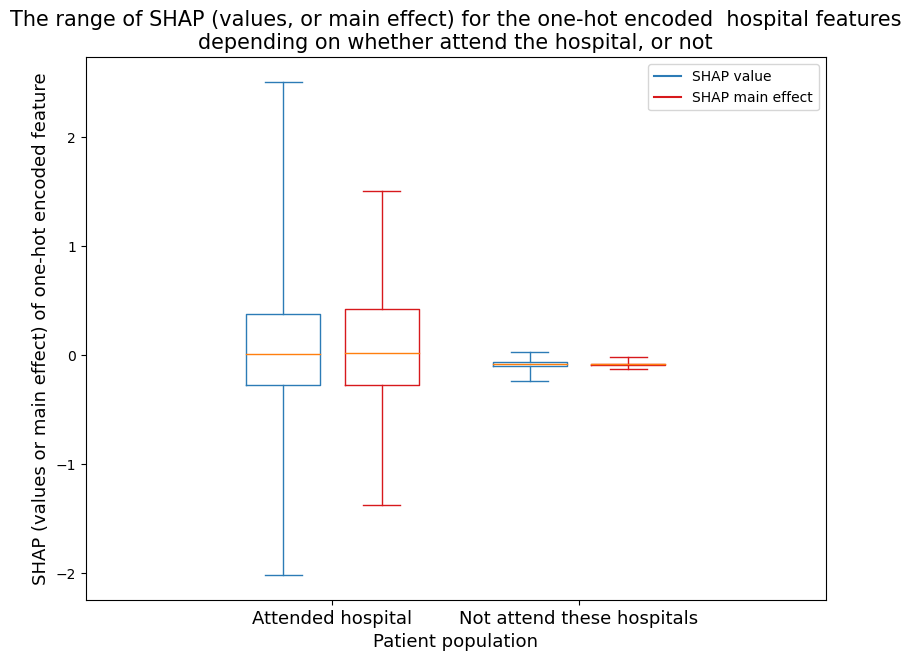

In [21]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ticks = ["Attended hospital", "Not attend these hospitals"]

plot_data_sv = [shap_values_attended_hospital, shap_values_not_attend_these_hospitals]
bp_sv = plt.boxplot(plot_data_sv, 
                  positions=np.array(range(len(plot_data_sv)))*2.0-0.4, 
                  sym='', whis=99999, widths=0.6)
set_box_color(bp_sv, '#2C7BB6')

plot_data_me = [shap_me_attended_hospital, shap_me_not_attend_these_hospitals]
bp_me = plt.boxplot(plot_data_me, 
                  positions=np.array(range(len(plot_data_me)))*2.0+0.4, 
                  sym='', whis=99999, widths=0.6)
set_box_color(bp_me, '#D7191C') # colors are from http://colorbrewer2.org/

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='SHAP value')
plt.plot([], c='#D7191C', label='SHAP main effect')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks, size=13)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()

title = ("The range of SHAP (values, or main effect) for the one-hot encoded "
         " hospital features\ndepending on whether attend the hospital, or not")
plt.title(title, size=15)
plt.ylabel('SHAP (values or main effect) of one-hot encoded feature', size=13)
plt.xlabel('Patient population', size=13)
plt.savefig(f'./output/{notebook}_{model_text}'
            f'_hosp_shap_value_and_main_effect_attend_vs_notattend_boxplot.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

#### Boxplot (individual hospitals)

Create a boxplot to show the range of SHAP values and SHAP main effect values for each individual one-hot encoded hospital feature. 

Show the SHAP value as two populations: 1) the group of instances that attend the hospital [black], and 2) the group of instances that do not attend the hosptial [orange].

Order the hospitals in descending order of mean SHAP value for the hospital the instance attended (so those that more often contribute to a yes-thrombolysis decision, through to those that most often contribute to a no-thrombolysis decision).

Firstly, to order the hospitals, create a dataframe containing the mean SHAP main effect, and mean SHAP values for each hosptial (for those instances that attended the hospital)

In [22]:
def shap_descriptive_stats(hospital_names, df_hosp_shap, prefix_text):
    # Create list of SHAP main effect values (one per hospital) for those instances
    #   that attend the hospital
    attend_stroketeam_min = []
    attend_stroketeam_q1 = []
    attend_stroketeam_mean = []
    attend_stroketeam_q3 = []
    attend_stroketeam_max = []
    for h in hospital_names:
        mask = df_hosp_shap['Stroke team'] == h
        data_stroke_team = df_hosp_shap[h][mask]
        q1, q3 = np.percentile(data_stroke_team, [25,75])
        attend_stroketeam_min.append(data_stroke_team.min())
        attend_stroketeam_q1.append(q1)
        attend_stroketeam_mean.append(data_stroke_team.mean())
        attend_stroketeam_q3.append(q3)
        attend_stroketeam_max.append(data_stroke_team.max())

    # Create dataframe with six columns (hospital and descriptive stats)
    df = pd.DataFrame(hospital_names, columns=[f"hospital_{prefix_text}"])
    df[f"shap_min_{prefix_text}"] = attend_stroketeam_min
    df[f"shap_q1_{prefix_text}"] = attend_stroketeam_q1
    df[f"shap_mean_{prefix_text}"] = attend_stroketeam_mean
    df[f"shap_q3_{prefix_text}"] = attend_stroketeam_q3
    df[f"shap_max_{prefix_text}"] = attend_stroketeam_max
    
    return(df)

In [23]:
df_me = shap_descriptive_stats(hospital_names, df_hosp_shap_main_effects, "me")
df_sv = shap_descriptive_stats(hospital_names, df_hosp_shap_values, "sv")

df_hosp_shap_descriptive_stats = df_me.join(df_sv)
df_hosp_shap_descriptive_stats.drop(columns=["hospital_sv"], inplace=True)
df_hosp_shap_descriptive_stats.rename(columns={"hospital_me": "hospital"}, 
                                      inplace=True)

In [24]:
# sort in descending SHAP main effect value order
df_hosp_shap_descriptive_stats.sort_values("shap_mean_me", 
                                           ascending=False, inplace=True)                
df_hosp_shap_descriptive_stats.head(5)

,hospital,shap_min_me,shap_q1_me,shap_mean_me,shap_q3_me,shap_max_me,shap_min_sv,shap_q1_sv,shap_mean_sv,shap_q3_sv,shap_max_sv
9,CNBGF2713O,1.195877,1.314107,1.351094,1.393786,1.508929,0.648626,1.160532,1.338743,1.513107,1.989456
25,GKONI0110I,0.767646,1.057928,1.110841,1.168451,1.358355,0.046286,0.888337,1.085008,1.286739,1.779779
65,NTPQZ0829K,0.797407,0.978037,1.006841,1.050939,1.206905,0.209000,0.763998,0.917956,1.126985,1.599991
62,MHMYL4920B,0.753430,0.946048,0.964972,0.986911,1.103224,0.130139,0.786147,0.933300,1.059232,1.476519
32,HPWIF9956L,0.750452,0.902049,0.956728,1.008806,1.169653,0.206888,0.652731,0.901027,1.152177,1.624375


Add admission figures to xlabel in boxplot

Create dataframe with admissions and thrombolysis rate per stroke team (index)

In [25]:
# Get Stroke team name, the stroke team admission numbers, and list of SHAP 
# values for each instance that attended the stroke team
unique_stroketeams_list = list(set(X_combined["Stroke team"]))
admissions = [X[f'team_{s}'].sum() for s in unique_stroketeams_list]

df_stroketeam_ivt_adms = pd.DataFrame(unique_stroketeams_list, 
                                      columns=["Stroke team"])
df_stroketeam_ivt_adms["Admissions"] = admissions
df_stroketeam_ivt_adms.set_index("Stroke team", inplace=True)
df_stroketeam_ivt_adms.sort_values("Admissions", ascending=True, inplace=True)

# Calculate IVT rate per hosptial
hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]

# Join IVT rate with admissions per hosptial
df_stroketeam_ivt_adms = df_stroketeam_ivt_adms.join(hosp_ivt_rate)

df_stroketeam_ivt_adms

,Admissions,Thrombolysis
Stroke team,,
JXJYG0100P,120,0.233333
VVDIY0129H,130,0.192308
YEXCH8391J,149,0.228188
CNBGF2713O,152,0.480263
XPABC1435F,166,0.216867
...,...,...
JINXD0311F,1377,0.368192
AKCGO9726K,1428,0.369748
OFKDF3720W,1488,0.228495


Create data for boxplot

In [26]:
# Go through to order of hospital in
hospital_order = df_hosp_shap_descriptive_stats["hospital"]
    
# Create list of SHAP main effect values (one per hospital) for instances that 
#   attend stroke team
me_attend_stroketeam_groups_ordered = []
sv_attend_stroketeam_groups_ordered = []    
# Create list of SHAP main effect values (one per hospital) for instances that 
#   do not attend stroke team
me_not_attend_stroketeam_groups_ordered = []
sv_not_attend_stroketeam_groups_ordered = []
# Create list of labels for boxplot "stroke team name (admissions)"
xlabel = []

# Through hospital in defined order (as determined above)
for h in hospital_order:
    # Attend
    mask = df_hosp_shap_main_effects['Stroke team'] == h
    me_attend_stroketeam_groups_ordered.append(
                                            df_hosp_shap_main_effects[h][mask])
    sv_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Not attend
    mask = df_hosp_shap_main_effects['Stroke team'] != h
    me_not_attend_stroketeam_groups_ordered.append(
                                            df_hosp_shap_main_effects[h][mask])
    sv_not_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Label
    ivt_rate = int(df_stroketeam_ivt_adms['Thrombolysis'].loc[h] * 100)
    xlabel.append(f"{h} ({df_stroketeam_ivt_adms['Admissions'].loc[h]}, "
                  f"{ivt_rate}%)")

Resource for using overall y min and max of both datasets on the 4 plots so have the same range
https://blog.finxter.com/how-to-find-the-minimum-of-a-list-of-lists-in-python/#:~:text=With%20the%20key%20argument%20of,of%20the%20list%20of%20lists.

Shows the range of contributions to the prediction from this hospital when patients attend this hosptial


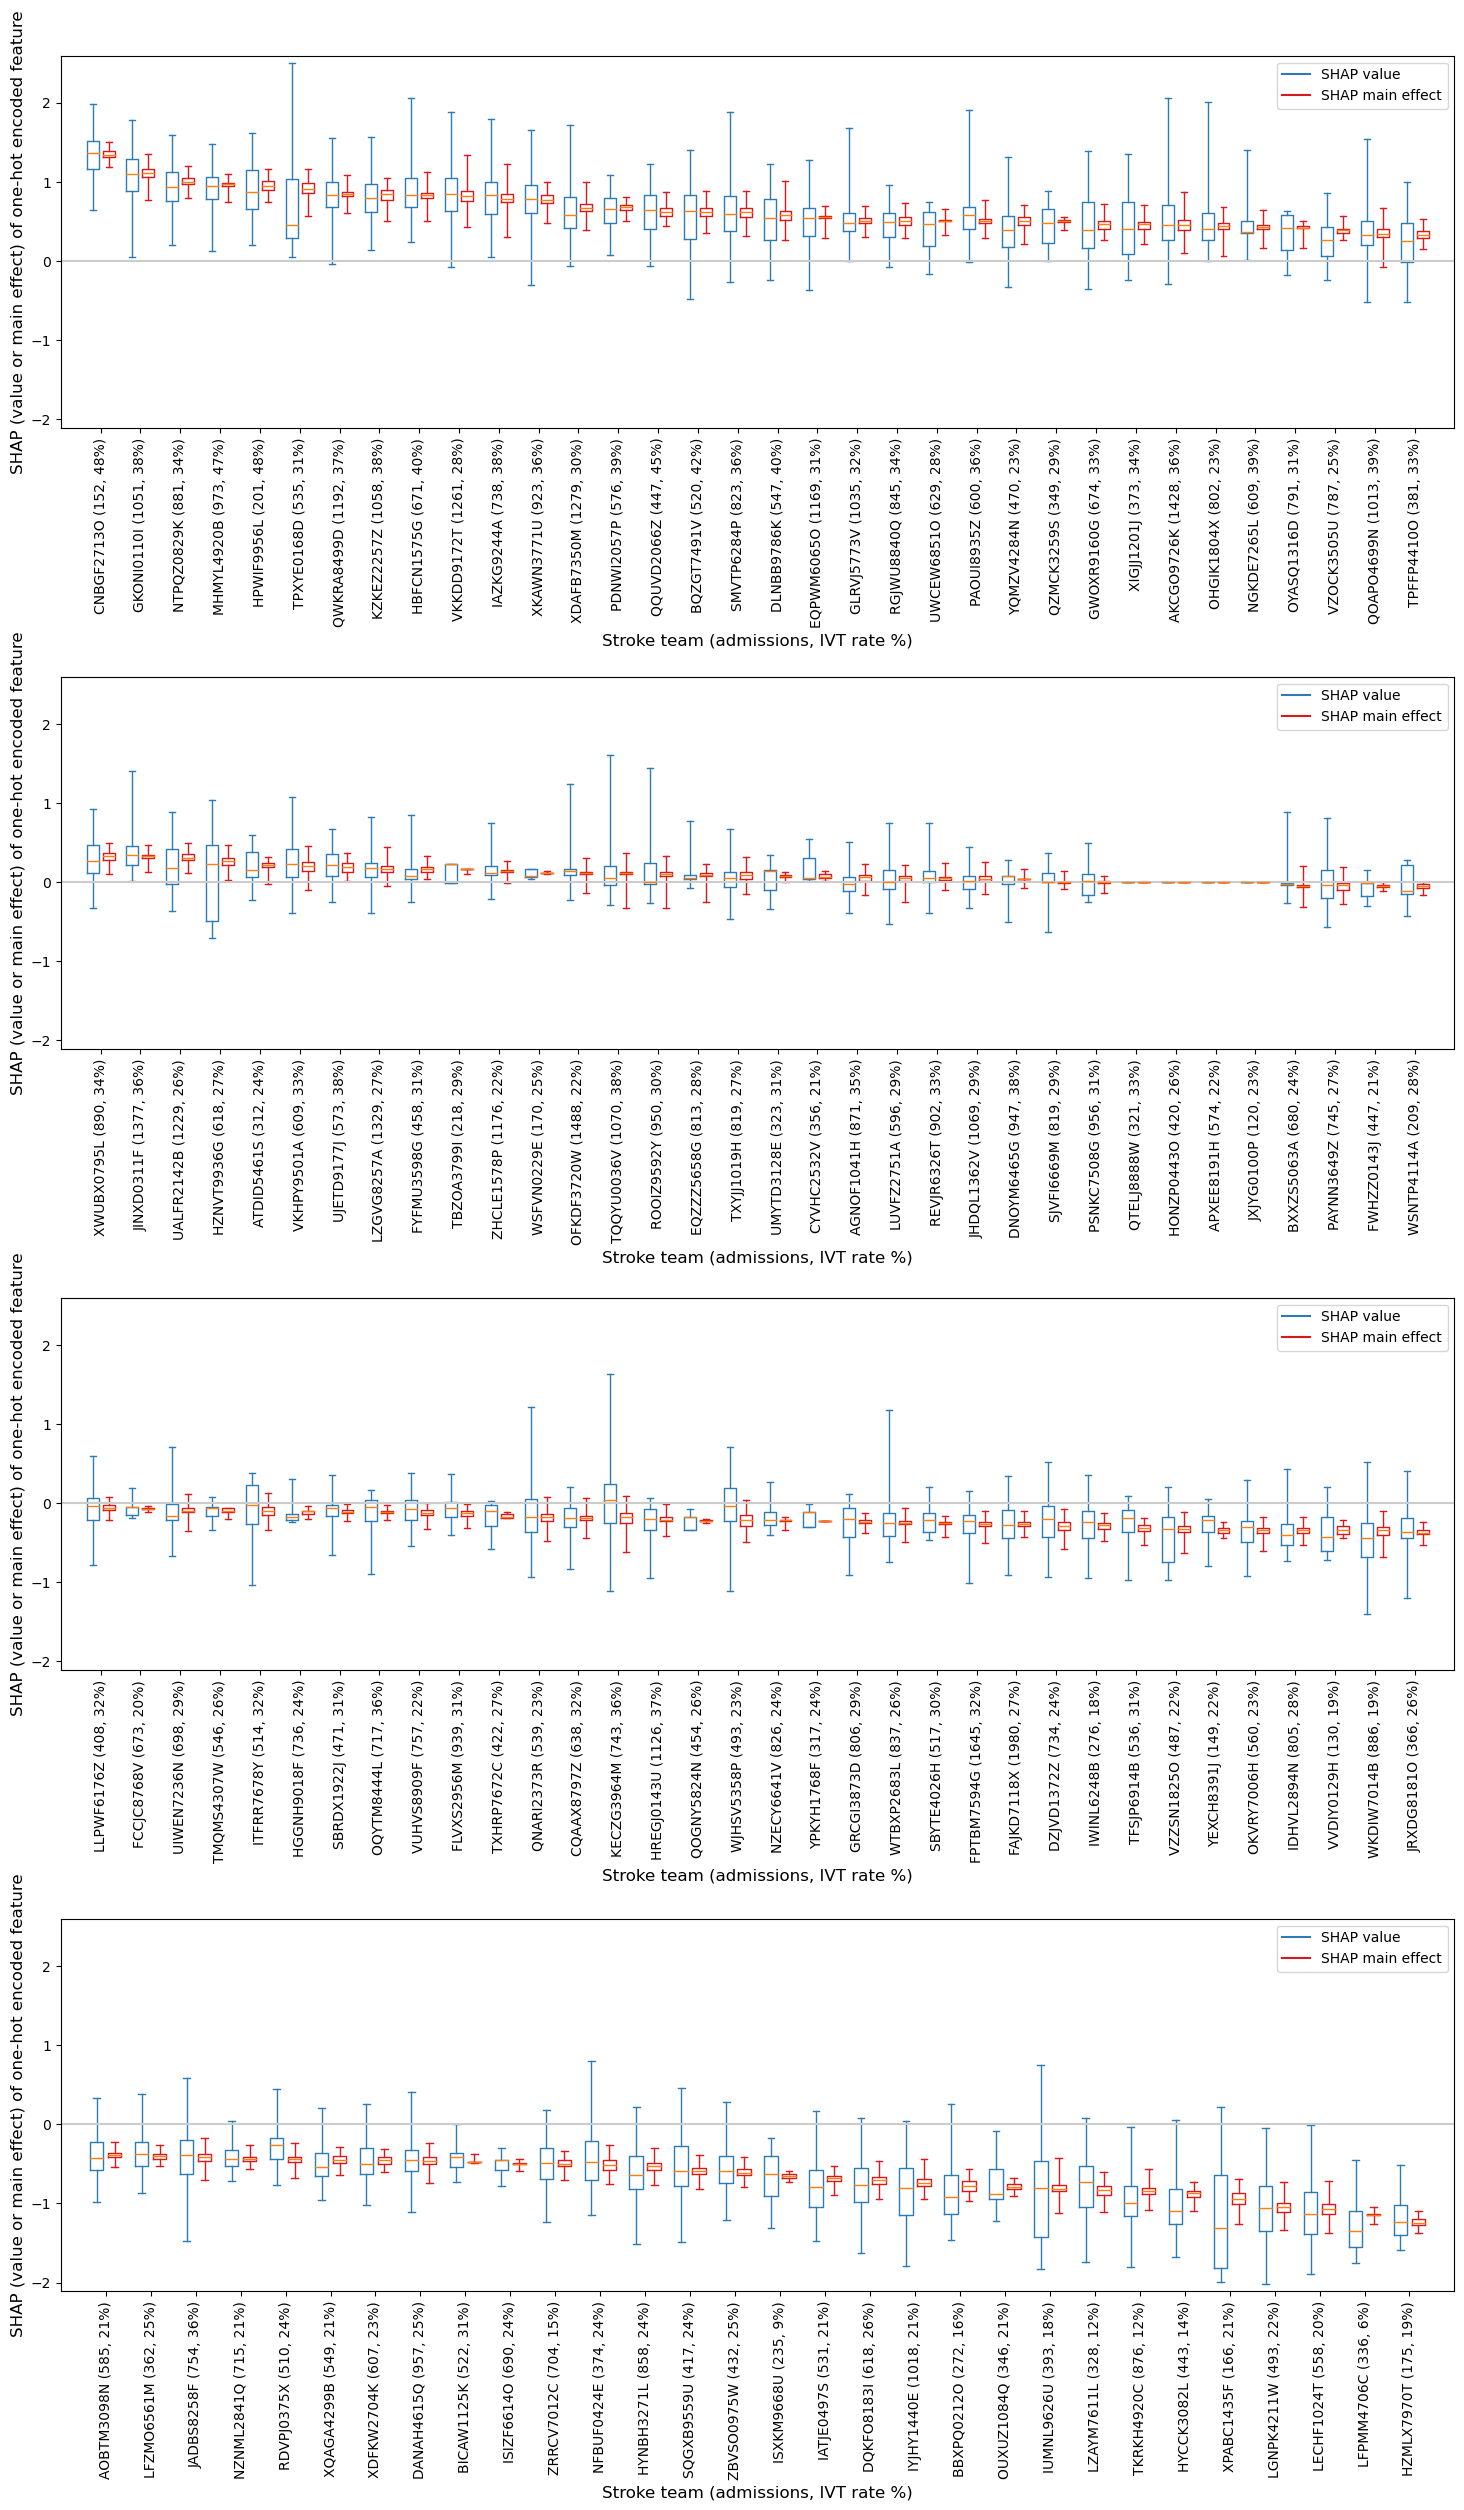

In [27]:
# Plot 34 hospitals on each figure to aid visually
print("Shows the range of contributions to the prediction from this hospital when patients attend "
      "this hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Use overall y min & max of both datasets on the 4 plots so have same range
ymin = min(min(sv_attend_stroketeam_groups_ordered, key=min))
ymax = max(max(sv_attend_stroketeam_groups_ordered, key=max))

# Adjust min and max to accommodate some wriggle room
yrange = ymax - ymin
ymin = ymin - yrange/50
ymax = ymax + yrange/50

# Create figure with 4 subplots
fig = plt.figure(figsize=(15,25))

# Create four subplots
for subplot in range(4):
    ax = fig.add_subplot(4,1,subplot+1)
    
    # "The contribution from this hospital when patients do not attend this hosptial"
    ticks = xlabel[st:ed]#hospital_order[st:ed]
    
    pos_sv = np.array(range(
                    len(sv_attend_stroketeam_groups_ordered[st:ed])))*2.0-0.4
    bp_sv = plt.boxplot(sv_attend_stroketeam_groups_ordered[st:ed], 
                        positions=pos_sv, sym='', whis=99999, widths=0.6)
    
    pos_me = np.array(range(len(
                        me_attend_stroketeam_groups_ordered[st:ed])))*2.0+0.4
    bp_me = plt.boxplot(me_attend_stroketeam_groups_ordered[st:ed], 
                        positions=pos_me, sym='', whis=99999, widths=0.6)
    
    # colors are from http://colorbrewer2.org/
    set_box_color(bp_me, '#D7191C') 
    set_box_color(bp_sv, '#2C7BB6')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#2C7BB6', label='SHAP value')
    plt.plot([], c='#D7191C', label='SHAP main effect')
    plt.legend()

    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.ylim(ymin, ymax)
    plt.tight_layout()
    
    # Add line at Shap = 0
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    
    plt.ylabel('SHAP (value or main effect) of one-hot encoded feature', size=12)
    plt.xlabel('Stroke team (admissions, IVT rate %)', size=12)
    plt.xticks(rotation=90)
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)
    
plt.subplots_adjust(bottom=0.25, wspace=0.05)    
plt.tight_layout(pad=2)
plt.savefig(f'./output/{notebook}_{model_text}_individual_hosp_shap_value_and_'
            f'main_effect_attend_vs_notattend_boxplot.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

Notice that when patients do not attend the hospital the range of the SHAP values are largely centred on zero.
When patients do attend hosptial, the range of SHAP values are largely one side of zero or the other (only a minority of hospitals have their interquartile range spanning zero).

In [28]:
def count_hospitals_in_(q1, q3):
    
    n_iqr_below_zero = q3 < 0
    n_iqr_spans_zero = q1 * q3
    n_iqr_above_zero = q1 > 0
    n_iqr_is_zero1 = q1 == 0
    n_iqr_is_zero2 = q3 == 0
    n_iqr_is_zero = n_iqr_is_zero1 * n_iqr_is_zero2
    
    return(n_iqr_below_zero, n_iqr_spans_zero, n_iqr_above_zero, n_iqr_is_zero)

In [29]:
(n_iqr_below_zero_me, n_iqr_spans_zero_me, 
 n_iqr_above_zero_me, n_iqr_is_zero_me) = (
            count_hospitals_in_(df_hosp_shap_descriptive_stats["shap_q1_me"], 
                                df_hosp_shap_descriptive_stats["shap_q3_me"]))
(n_iqr_below_zero_sv, n_iqr_spans_zero_sv, 
 n_iqr_above_zero_sv, n_iqr_is_zero_sv) = (
            count_hospitals_in_(df_hosp_shap_descriptive_stats["shap_q1_sv"], 
                                df_hosp_shap_descriptive_stats["shap_q3_sv"]))

print (f"Number hospitals whose interquartile range is below zero. "
       f"Main effect: {n_iqr_below_zero_me.sum()}."
       f" Shap values: {n_iqr_below_zero_sv.sum()}")
print (f"Number hospitals whose interquartile range spans zero. "
       f"Main effect: {n_iqr_spans_zero_me.lt(0).sum()}. "
       f"Shap values: {n_iqr_spans_zero_sv.lt(0).sum()}")
print (f"Number hospitals whose interquartile range is above zero. "
       f"Main effect: {n_iqr_above_zero_me.sum()}. "
       f"Shap values: {n_iqr_above_zero_sv.sum()}")
print (f"Number hospitals whose interquartile range is zero. "
       f"Main effect: {n_iqr_is_zero_me.sum()}. "
       f"Shap values: {n_iqr_is_zero_sv.sum()}")

Number hospitals whose interquartile range is below zero. Main effect: 68. Shap values: 58
Number hospitals whose interquartile range spans zero. Main effect: 2. Shap values: 24
Number hospitals whose interquartile range is above zero. Main effect: 58. Shap values: 46
Number hospitals whose interquartile range is zero. Main effect: 4. Shap values: 4


How does the SHAP value for the one-hot encoded hospital features compare to the thrombolysis rate of the hospital?

Create dataframe containing the hospital's IVT rate and SHAP value (for those patients that attend the hospital).

In [30]:
# Calculate IVT rate per hosptial
hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]

# Join IVT rate with mean SHAP value per hosptial
df_hosp_plot = df_hosp_shap_descriptive_stats[["shap_mean_sv","hospital"]].copy(deep=True)
#df_hosp_plot.rename(columns={'shap_mean':'shap_value_mean'}, inplace=True)
df_hosp_plot.set_index("hospital", inplace=True)
df_hosp_plot = df_hosp_plot.join(hosp_ivt_rate)

# Join IVT rate with mean SHAP main effect per hosptial
temp = df_hosp_shap_descriptive_stats[["shap_mean_me","hospital"]].copy(deep=True)
#temp.rename(columns={'shap_mean':'shap_main_effect_mean'}, inplace=True)
temp.set_index("hospital", inplace=True)
df_hosp_plot = df_hosp_plot.join(temp)

Plot SHAP value for one-hot encoded hospital feature (mean for those instances that attend the hospital) vs hospital IVT rate

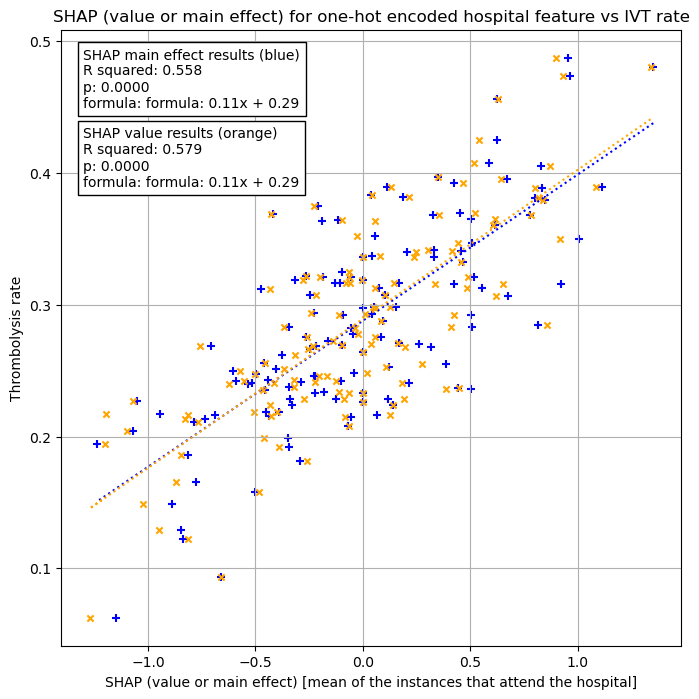

In [31]:
# Setup data for chart
x1 = df_hosp_plot['shap_mean_me']
x2 = df_hosp_plot['shap_mean_sv']
y = df_hosp_plot['Thrombolysis']

# Save data
df_hosp_plot.to_csv(f'./output/{notebook}_{model_text}_shap_vs_thrombolysis.csv')

# Fit a regression line to the x1 points
slope1, intercept1, r_value1, p_value1, std_err1 = \
    stats.linregress(x1, y)
r_square1 = r_value1 ** 2
y_pred1 = intercept1 + (x1 * slope1)

# Fit a regression line to the x2 points
slope2, intercept2, r_value2, p_value2, std_err2 = \
    stats.linregress(x2, y)
r_square2 = r_value2 ** 2
y_pred2 = intercept2 + (x2 * slope2)

# Create scatter plot with regression line
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(x1, y, color = "blue", marker="+", s=30)
ax.scatter(x2, y, color = "orange", marker="x", s=20)

ax.plot (x1, y_pred1, color = 'blue', linestyle=':')
f1 = ('formula: ' + str("{:.2f}".format(slope1)) + 'x + ' + 
      str("{:.2f}".format(intercept1)))
text1 = (f'SHAP main effect results (blue)\nR squared: {r_square1:.3f}\np: '
         f'{p_value1:0.4f}\nformula: {f1}')
ax.text(-1.3, 0.45, text1, 
         bbox=dict(facecolor='white', edgecolor='black'))

ax.plot (x2, y_pred2, color = 'orange', linestyle=':')
f2 = ('formula: ' + str("{:.2f}".format(slope2)) + 'x + ' + 
      str("{:.2f}".format(intercept2)))
text2 = (f'SHAP value results (orange)\nR squared: {r_square2:.3f}\np: '
         f'{p_value2:0.4f}\nformula: {f2}')
ax.text(-1.3, 0.39, text2, 
         bbox=dict(facecolor='white', edgecolor='black'))

ax.set_xlabel("SHAP (value or main effect) "
              "[mean of the instances that attend the hospital]")
ax.set_ylabel('Thrombolysis rate')
ax.set_title("SHAP (value or main effect) for one-hot encoded hospital feature "
             "vs IVT rate")
plt.grid()

plt.savefig(f'./output/{notebook}_{model_text}'
            f'_attended_hosp_shap_value_and_main_effect_vs_ivt_rate.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

Plot full SHAP effect only

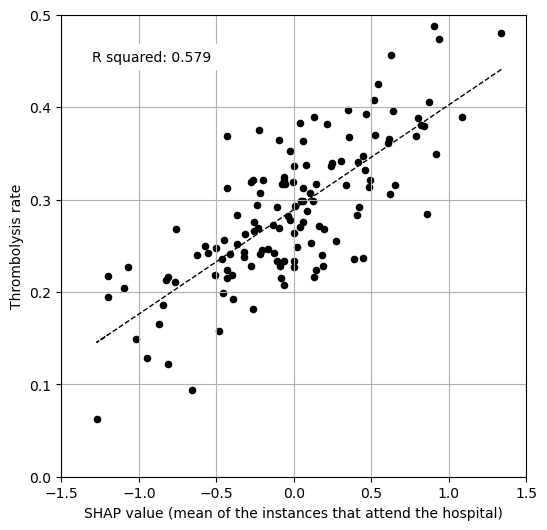

In [32]:
# Setup data for chart
x1 = df_hosp_plot['shap_mean_me']
x2 = df_hosp_plot['shap_mean_sv']
y = df_hosp_plot['Thrombolysis']

# Fit a regression line to the x2 points
slope2, intercept2, r_value2, p_value2, std_err2 = \
    stats.linregress(x2, y)
r_square2 = r_value2 ** 2
y_pred2 = intercept2 + (x2 * slope2)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.scatter(x2, y, color = 'k', marker="o", s=20)
ax.plot (x2, y_pred2, color = 'k', linestyle='--', linewidth=1)

ax.set_xlabel("SHAP value "
              "(mean of the instances that attend the hospital)")
ax.set_ylabel('Thrombolysis rate')

ax.set_ylim(0, 0.5)
ax.set_xlim(-1.5, 1.5)


plt.grid()

# Add  text

text2 = (f'R squared: {r_square2:.3f}')
ax.text(-1.3, 0.45, text2, 
         bbox=dict(facecolor='white', edgecolor='white'))

# Save figure

plt.savefig(f'./output/{notebook}_{model_text}'
            f'_attended_hosp_shap_value.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [34]:
# Save table
filename = (f'./output/03c_{model_text}'
            f'_attended_hosp_shap_value.csv')

df_hosp_plot.to_csv(filename)

: 

### Observations
* Both of the SHAP values and SHAP main effect values for the one-hot encoded hospital features are very dependent on whether the instance attended the hospital or not
* For the instances that attend a hospital, the SHAP main effect values are a narrower range than the equivalent SHAP values (due to the SHAP values being made up of the main effect and the pair-wise feature interactions).
* 56% of the variability in hospital thrombolysis rate can be explained by the SHAP main effect value for the one-hot encoded hospital feature (the mean of those instances that attend the hospital).
* 58% of the variability in hospital thrombolysis rate can be explained by the SHAP main effect value for the one-hot encoded hospital feature (the mean of those instances that attend the hospital).